![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Image Classification with Transformers

In [0]:
from johnsnowlabs import * 

# **Identify Receipts in Pictures**

![3.png](/files/FINLEG/3.png)

🔎 With this model, you can detect Receipts on both scanned and mobile images using Financial Image Transformers (ViT) in Spark NLP. You can use this model to retrieve all the images which are tickets and then process then using VisualNER, OCR, etc.

🔎 **`finvisualclf_tickets`** is a ViT (Visual Transformer) model, which can be used to carry out Binary Classification (true or false) on pictures / photos / images. This model has been trained in-house with different corpora, including:

* CORD
* COCO
* In-house annotated tickets

🔎 Classes detected by the model:

* **ticket**
* **no_ticket**

## Load test images

In [0]:
dbutils.fs.mkdirs("dbfs:/Finance")
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image01.png
dbutils.fs.cp("file:/databricks/driver/image01.png", "dbfs:/Finance") 
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image02.png
dbutils.fs.cp("file:/databricks/driver/image02.png", "dbfs:/Finance") 
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image03.png
dbutils.fs.cp("file:/databricks/driver/image03.png", "dbfs:/Finance") 
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image04.png
dbutils.fs.cp("file:/databricks/driver/image04.png", "dbfs:/Finance") 
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image05.png
dbutils.fs.cp("file:/databricks/driver/image05.png", "dbfs:/Finance") 
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image06.png
dbutils.fs.cp("file:/databricks/driver/image06.png", "dbfs:/Finance") 

Out[10]: True

In [0]:
test_image = spark.read\
    .format("image")\
    .option("dropInvalid", value = True)\
    .load("dbfs:/Finance/*.png").toDF("image")


In [0]:
test_image.select("image.origin", "image.width", "image.height").show(truncate=False)

+-------------------------+-----+------+
origin |width|height|
+-------------------------+-----+------+
dbfs:/Finance/image05.png|960 |1280 |
dbfs:/Finance/image01.png|1108 |1478 |
dbfs:/Finance/image02.png|1920 |2889 |
dbfs:/Finance/image06.png|1556 |1760 |
dbfs:/Finance/image04.png|1275 |1650 |
dbfs:/Finance/image03.png|1108 |1478 |
+-------------------------+-----+------+

# Prediction Pipeline

In [0]:
document_assembler = nlp.ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

imageClassifier_loaded = nlp.ViTForImageClassification.pretrained("finvisualclf_vit_tickets", "en", "finance/models")\
  .setInputCols(["image_assembler"])\
  .setOutputCol("classes")

pipeline = Pipeline().setStages([
                            document_assembler,
                            imageClassifier_loaded])

finvisualclf_vit_tickets download started this may take some time.
Approximate size to download 306.9 MB
[ | ][OK!]

# Call pipeline

In [0]:
result = pipeline.fit(test_image).transform(test_image).cache()

# Show results

In [0]:
result.show()

+--------------------+--------------------+--------------------+
 image| image_assembler| classes|
+--------------------+--------------------+--------------------+
{dbfs:/Finance/im...|[{image, dbfs:/Fi...|[{category, 0, 5,...|
{dbfs:/Finance/im...|[{image, dbfs:/Fi...|[{category, 0, 5,...|
{dbfs:/Finance/im...|[{image, dbfs:/Fi...|[{category, 0, 8,...|
{dbfs:/Finance/im...|[{image, dbfs:/Fi...|[{category, 0, 8,...|
{dbfs:/Finance/im...|[{image, dbfs:/Fi...|[{category, 0, 8,...|
{dbfs:/Finance/im...|[{image, dbfs:/Fi...|[{category, 0, 5,...|
+--------------------+--------------------+--------------------+

In [0]:
result.printSchema()

root
-- image: struct (nullable = true)
 |-- origin: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- nChannels: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- data: binary (nullable = true)
-- image_assembler: array (nullable = true)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- origin: string (nullable = true)
 | |-- height: integer (nullable = false)
 | |-- width: integer (nullable = false)
 | |-- nChannels: integer (nullable = false)
 | |-- mode: integer (nullable = false)
 | |-- result: binary (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
-- classes: array (nullable = true)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
result_df = result.select(F.explode(F.arrays_zip(result.classes.result,result.classes.metadata)).alias("cols"))\
                  .select(F.expr("cols['1']['origin']").alias("images"),
                          F.expr("cols['0']").alias("class"),
                          F.expr("cols['1']['Some(ticket)']").alias("ticket_confidence"),
                          F.expr("cols['1']['Some(no_ticket)']").alias("no_ticket_confidence"))
                          

result_df.show(truncate=False)

+-------------------------+---------+-----------------+--------------------+
images |class |ticket_confidence|no_ticket_confidence|
+-------------------------+---------+-----------------+--------------------+
dbfs:/Finance/image05.png|ticket |0.9947879 |0.0052121 |
dbfs:/Finance/image01.png|ticket |0.9956969 |0.004303069 |
dbfs:/Finance/image02.png|no_ticket|8.144786E-4 |0.9991855 |
dbfs:/Finance/image06.png|no_ticket|8.130499E-4 |0.99918693 |
dbfs:/Finance/image04.png|no_ticket|8.138704E-4 |0.99918616 |
dbfs:/Finance/image03.png|ticket |0.99545777 |0.004542244 |
+-------------------------+---------+-----------------+--------------------+

Out[61]:

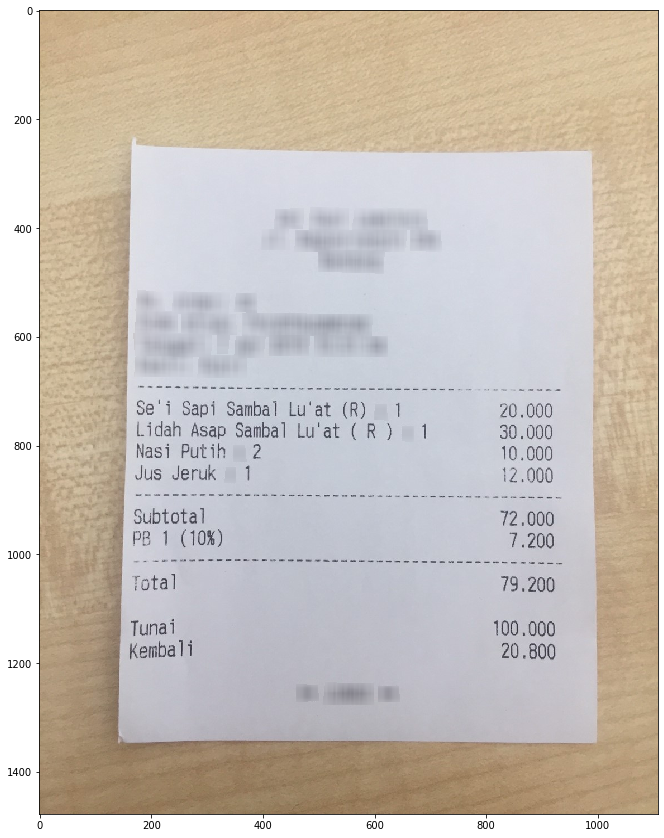

<matplotlib.image.AxesImage at 0x7fab94f8c130>

In [0]:
from PIL import Image            # to load images
import matplotlib.pyplot as plt

image_path = '/dbfs/Finance/image01.png'
pil_im = Image.open(image_path)
width, height = pil_im.size
dpi=100
plt.figure(figsize = (width/dpi,height/dpi))
plt.imshow(pil_im, interpolation='nearest', aspect='auto')


In [0]:
result_df.filter(result_df.images == 'dbfs:/Finance/image01.png').select("class").show()

+------+
 class|
+------+
ticket|
+------+

Out[60]:

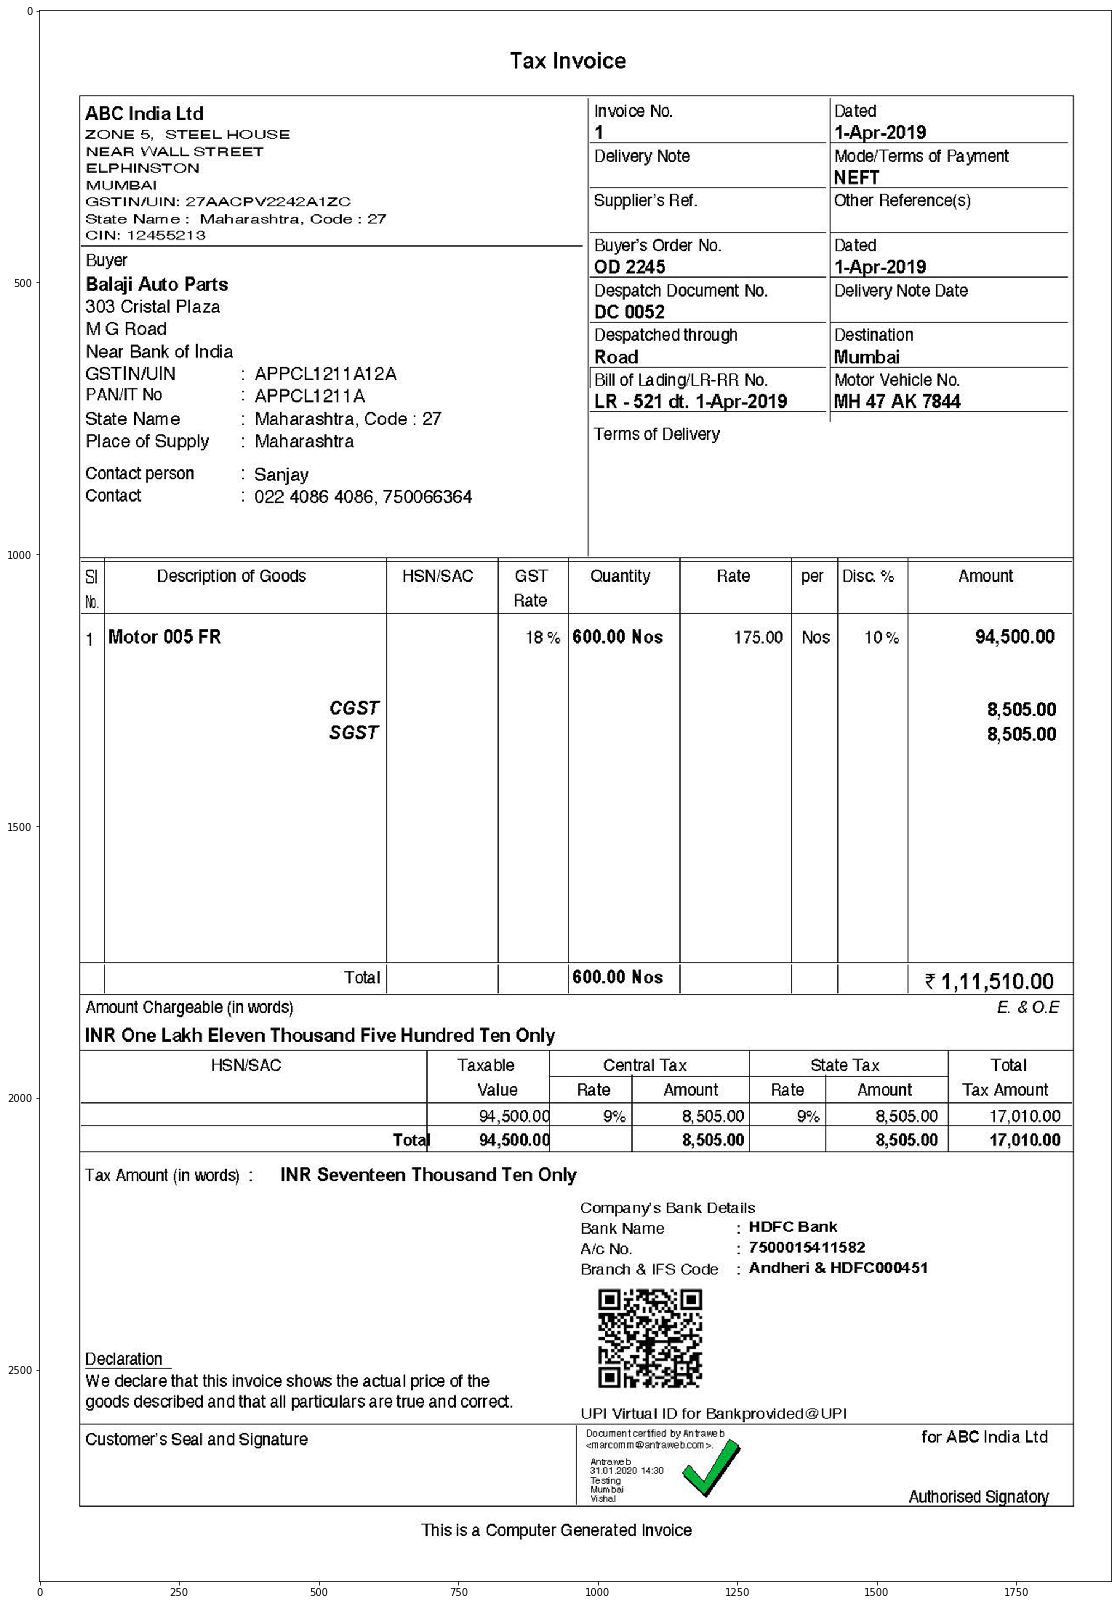

<matplotlib.image.AxesImage at 0x7fab950222b0>

In [0]:
image_path = '/dbfs/Finance/image02.png'
pil_im = Image.open(image_path)
width, height = pil_im.size
dpi=100
plt.figure(figsize = (width/dpi,height/dpi))
plt.imshow(pil_im, interpolation='nearest', aspect='auto')

In [0]:
result_df.filter(result_df.images == 'dbfs:/Finance/image01.png').select("class").show()

+------+
 class|
+------+
ticket|
+------+